### TODOs

- [x] Increase charts size
- [x] Make notes for the presentation
- [x] Data analysis: simulate real entrance frequency
- [ ] Data analysis: plot time in a section
- [x] Package simulation as a class
- [ ] Plotly instead of pandas plots
- [ ] Data analysis: plot count of cusomer's paths

# Project: Monte Carlo Markov Chain Simulation

## Business goals:  

1. understand customer behavior  
2. explain customer behavior to non-data staff  
3. optimize staffing so that the queues do not get unnecessary long  

### Supermarket Area

We are using the following model supermarket with six areas: entrance, fruit, spices, dairy, drinks and checkout.

The customers can move between these areas freely. Sooner or later, they will enter the checkout area. Once they do, they are considered to have left the shop.

![Drag Racing](./supermarket.png)

### Load packages

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 8)

### Load data

In [2]:
def load_day_data(day):
    return load_data(os.path.join('./data/', day + '.csv'))

def load_data(path):
    return pd.read_csv(path, sep=';', parse_dates=['timestamp'], index_col=['timestamp'])

df = load_day_data('monday')
for file in ['tuesday', 'wednesday', 'thursday', 'friday']:
    df_next = load_day_data(file)
    df_next['customer_no'] = df_next['customer_no'] + df['customer_no'].max()
    df = df.append(df_next)

# df

### Enrich data

In [3]:
def resample_transitions(df):
    df_full = df.groupby(by=['customer_no']).resample('1T').pad().drop(columns=['customer_no']).reset_index()
    df_full['location_before'] = df_full.groupby(by=['customer_no'])['location'].shift(fill_value='entrance')

    # When the shop closes, the remaining customers are rushed through the checkout. 
    # Their checkout is not recorded, so it may look as if they stay in the market forever.
    # Here we add last transition for such customers
    last_locations = df_full.groupby(by='customer_no')[['timestamp', 'location']].last()
    missing_checkouts = last_locations[last_locations['location'] != 'checkout'].copy()
    missing_checkouts['timestamp'] = missing_checkouts['timestamp'] + pd.Timedelta(minutes=1)
    missing_checkouts['location_before'] = missing_checkouts['location']
    missing_checkouts['location'] = 'checkout'
    missing_checkouts.reset_index(inplace=True)

    return df_full.append(missing_checkouts)

df_full = resample_transitions(df)
df_full

,customer_no,timestamp,location,location_before
0,1,2019-09-02 07:03:00,dairy,entrance
1,1,2019-09-02 07:04:00,dairy,dairy
2,1,2019-09-02 07:05:00,checkout,dairy
3,2,2019-09-02 07:03:00,dairy,entrance
4,2,2019-09-02 07:04:00,dairy,dairy
...,...,...,...,...
23,7438,2019-09-06 21:50:00,checkout,drinks
24,7440,2019-09-06 21:50:00,checkout,dairy
25,7441,2019-09-06 21:49:00,checkout,dairy
26,7444,2019-09-06 21:51:00,checkout,drinks


## Data analysis

### When customers enter the supermarket?

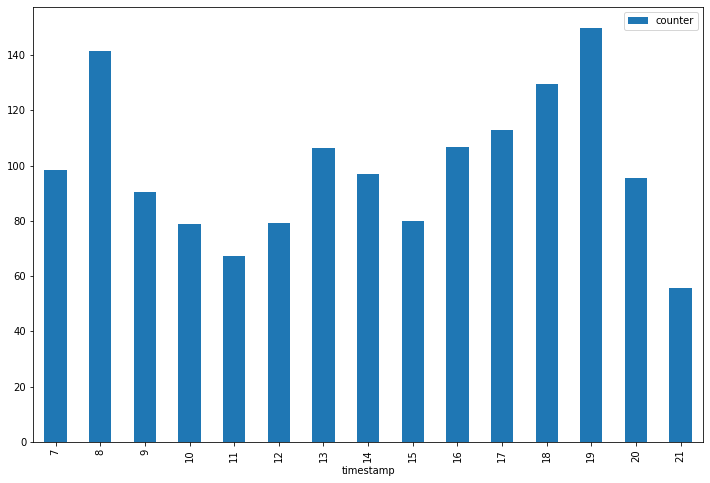

In [4]:
def show_new_customers_per_hour(df):
    """ plots daily avg distribution customers entering the store per hour """
    days_cnt = len(df.index.day.unique())
    tmp = df.reset_index().groupby('customer_no')[['timestamp']].min()
    tmp['counter'] = 1 / days_cnt
    tmp.groupby([tmp['timestamp'].dt.hour])[['counter']].sum().plot.bar()

show_new_customers_per_hour(df)

### How many customers are in store?

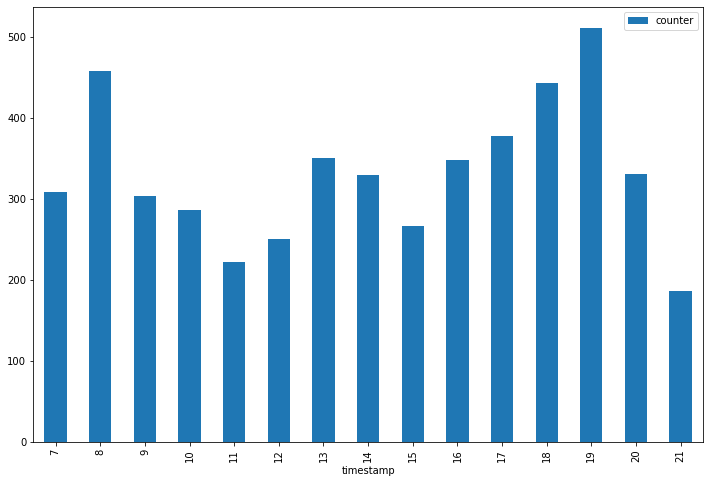

In [5]:
def show_number_of_customers_in_store(df):
    days_cnt = len(df.index.day.unique())
    tmp = df.reset_index()
    tmp['counter'] = 1 / days_cnt
    tmp.groupby([tmp['timestamp'].dt.hour])[['counter']].sum().plot.bar()
    
show_number_of_customers_in_store(df)

### How long users spend in the supermarket?

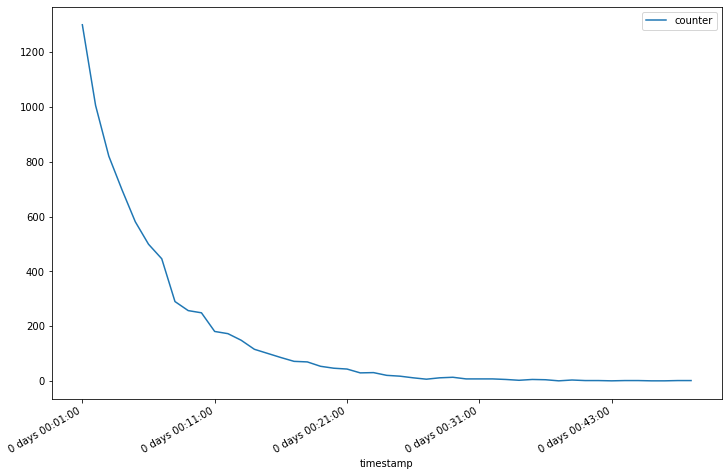

In [6]:
def plot_time_in_supermarket(df):
    g = df.reset_index().groupby(['customer_no'])[['timestamp']]
    time_in_market = g.last() - g.first()
    time_in_market['counter'] = 1
    time_in_market.groupby(['timestamp']).count().plot()

plot_time_in_supermarket(df_full)

### Probabilities plot

what are the chances to be in a specific section?

In [7]:
def build_transitions_matrix(df_full):
    crosstab = pd.crosstab(df_full['location_before'], df_full['location'], normalize=0)
    crosstab['entrance'] = 0
    values = dict(zip(crosstab.columns, [1, 0, 0, 0, 0, 0]))
    crosstab = crosstab.append(pd.DataFrame(values, index=['checkout']))
    crosstab = crosstab.reindex(sorted(crosstab.columns), axis=1)
    crosstab = crosstab.reindex(sorted(crosstab.index), axis=0)

    return crosstab

crosstab = build_transitions_matrix(df_full)
# crosstab

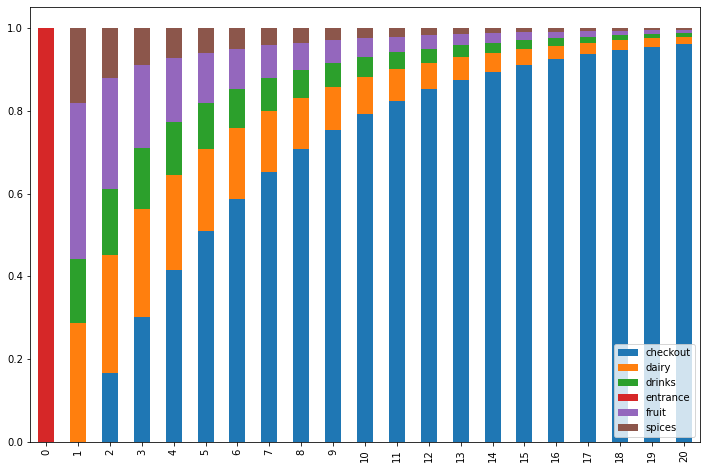

In [8]:
def show_step_probabilities_plot(crosstab):
    initial_state = []
    for column in crosstab.columns:
        initial_state.append(int(column == 'entrance'))

    state = initial_state
    lines = pd.DataFrame([state], columns=crosstab.columns)
    for i in range(0,20):
        state = np.dot(state, crosstab.values)
        lines = lines.append(pd.DataFrame([state], columns=crosstab.columns))
    lines = lines.reset_index()
    del lines['index']
    lines.plot.bar(stacked=True)


show_step_probabilities_plot(crosstab)

### How many sections customer visited before leaving the supermarket?

In [9]:
# TODO

### Revenue Estimate

In [10]:
# TODO

## Markov chain

### Transitions matrix

In [11]:
crosstab = build_transitions_matrix(df_full)
crosstab.to_csv('./output/transition_matrix.csv', sep=';')
crosstab

,checkout,dairy,drinks,entrance,fruit,spices
checkout,1.000000,0.000000,0.000000,0,0.000000,0.000000
dairy,0.103466,0.736750,0.058569,0,0.049848,0.051367
drinks,0.215710,0.010899,0.598499,0,0.087909,0.086983
entrance,0.000000,0.287576,0.153526,0,0.377435,0.181464
fruit,0.201605,0.095924,0.054847,0,0.596947,0.050677
spices,0.150685,0.193214,0.163109,0,0.090953,0.402039


### Monte carlo simulations

#### Simulation 1

In [12]:
from mcmc_simulator import McmcSimulator

In [13]:
matrix=pd.read_csv('./output/transition_matrix.csv', index_col=0, sep=';')

simulation1_file = './output/simulation-1.csv'

McmcSimulator.run(
    matrix,
    output_file=simulation1_file,
    customers_per_minute=lambda clock: 1 # one customer per minute
)

In [14]:
df_s1 = load_data(simulation1_file)
df_s1_full = resample_transitions(df_s1)

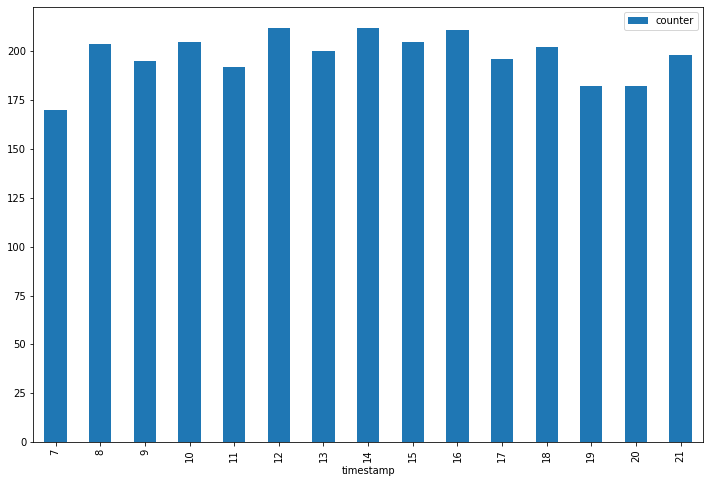

In [15]:
show_number_of_customers_in_store(df_s1)
# df_s1

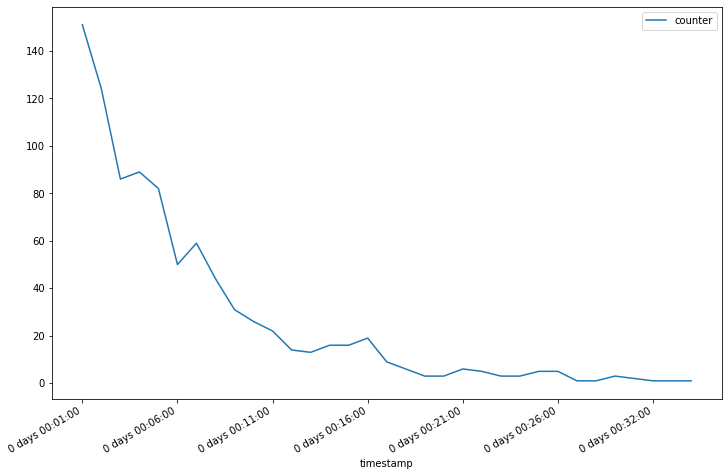

In [16]:
plot_time_in_supermarket(df_s1_full)

#### Simulation 2

In [17]:
from clock import Clock

def real_customers_distribution(clock: Clock) -> int:
    """
    this function returns number of customers that enter the store every minute
    this number depends on the hour and may vary from minute to minute
    """
    d = {
        7: 98, # customers per hour
        8: 141,
        9: 91,
        10: 79,
        11: 67,
        12: 79,
        13: 106,
        14: 97,
        15: 80,
        16: 107,
        17: 113,
        18: 130,
        19: 150,
        20: 96,
        21: 56
    }
    
    return np.random.poisson(d[clock.hour] / 60, 1)[0]
    
# cb(Clock('2021-11-18 09:00:00'))

In [18]:
simulation2_file = './output/simulation-2.csv'

McmcSimulator.run(
    matrix,
    output_file=simulation2_file,
    customers_per_minute=real_customers_distribution
)

In [19]:
df_s2 = load_data(simulation2_file)
df_s2_full = resample_transitions(df_s2)

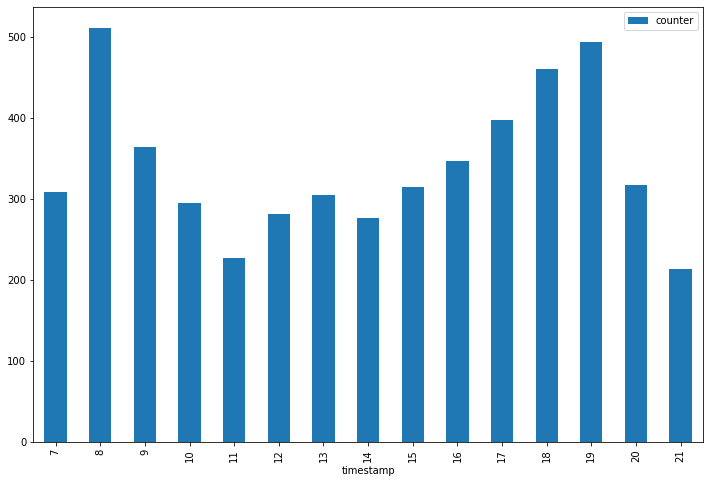

In [20]:
show_number_of_customers_in_store(df_s2)

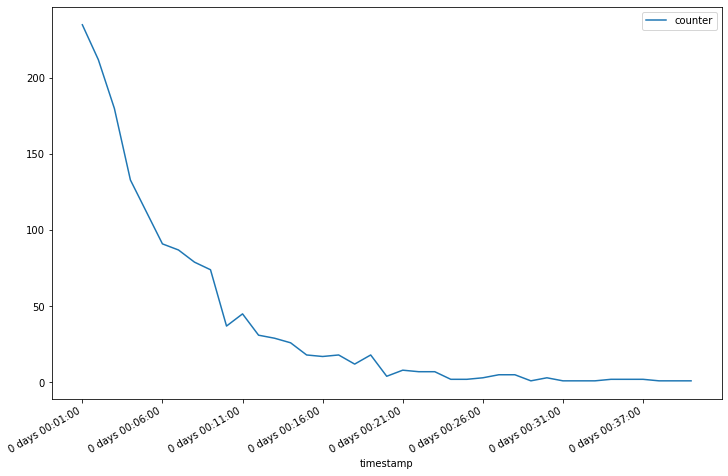

In [21]:
plot_time_in_supermarket(df_s2_full)